In [90]:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Attention, Input,LSTM, Bidirectional, Dense, Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# import warnings
# warnings.filterwarnings("ignore")

In [29]:
df = pd.read_csv("data/reviews.csv")

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [31]:
df.shape

(568454, 10)

In [32]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [33]:
df.dropna(axis=0, inplace=True)
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [34]:
#contraction map dict
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [35]:
#stopwords
stop_words = set(stopwords.words("english"))

def preprocess(text):
  #lower case
  text = text.lower()
  # remove tags
  #text = BeautifulSoup(text, "lxml").text
  #remove text inside parenthesis
  text = re.sub(r'\([^)]*\)',"",text)
  #remove double quotes
  text = re.sub('"', '', text)
  #eliminate punctuations and special characters
  text = re.sub("[^a-zA-Z]", " ", text)
  #contraction mapping
  text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
  #remove 's
  text = re.sub(r"'s\b","", text)
  #remove stopwords 
  words = [w for w in text.split() if w not in stop_words]
  #removing short words
  long_words = []
  for i in words:
    if len(i)>1:
      long_words.append(i)
  text = (" ".join(long_words)).strip()
  return text

In [36]:
df['processed_text'] = df['Text'].apply(lambda x: preprocess(x))
df['processed_text']

0         bought several vitality canned dog food produc...
1         product arrived labeled jumbo salted peanuts p...
2         confection around centuries light pillowy citr...
3         looking secret ingredient robitussin believe f...
4         great taffy great price wide assortment yummy ...
                                ...                        
568449    great sesame chicken good better resturants ea...
568450    disappointed flavor chocolate notes especially...
568451    stars small give one training session tried tr...
568452    best treats training rewarding dog good groomi...
568453    satisfied product advertised use cereal raw vi...
Name: processed_text, Length: 568401, dtype: object

In [37]:
df['processed_summary'] = df['Summary'].apply(lambda x: preprocess(x))
df['processed_summary']

0                  good quality dog food
1                             advertised
2                           delight says
3                         cough medicine
4                            great taffy
                       ...              
568449                           without
568450                      disappointed
568451                  perfect maltipoo
568452    favorite training reward treat
568453                       great honey
Name: processed_summary, Length: 568401, dtype: object

In [38]:
df["processed_summary"] = df["processed_summary"].apply(lambda x: 'sos '+ x + ' eos')
df["processed_summary"]

0                  sos good quality dog food eos
1                             sos advertised eos
2                           sos delight says eos
3                         sos cough medicine eos
4                            sos great taffy eos
                           ...                  
568449                           sos without eos
568450                      sos disappointed eos
568451                  sos perfect maltipoo eos
568452    sos favorite training reward treat eos
568453                       sos great honey eos
Name: processed_summary, Length: 568401, dtype: object

In [52]:
text_count = []
summary_count = []
for i in df['processed_text']:
  text_count.append(len(i.split()))
  
for i in df['processed_summary']:
  summary_count.append(len(i.split()))


<Axes: ylabel='Count'>

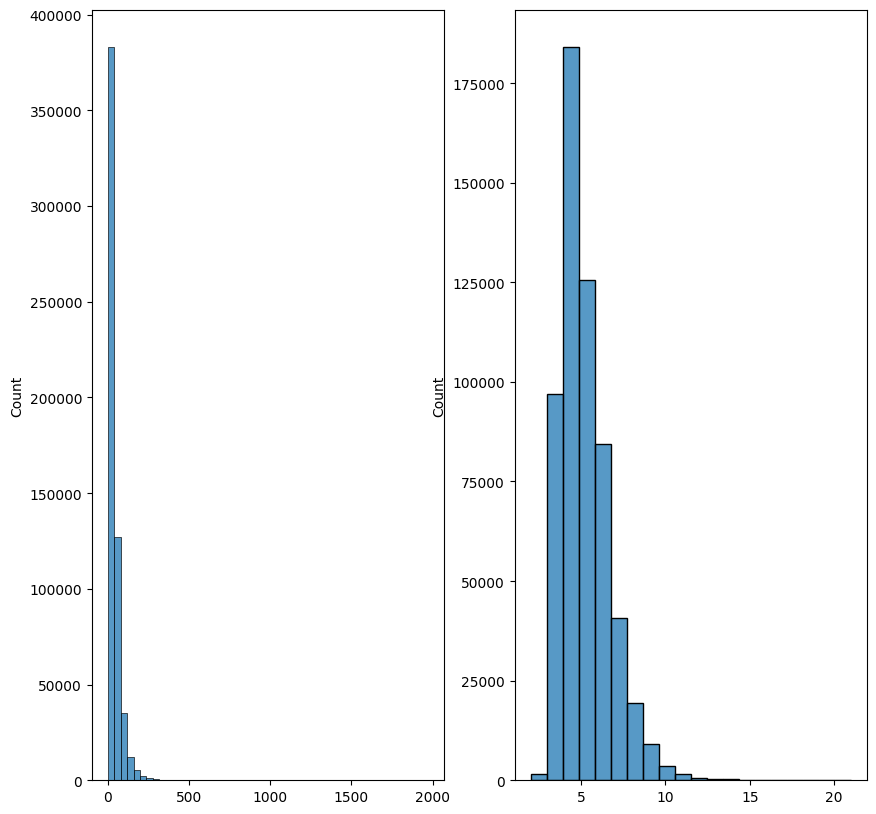

In [61]:
plt.figure(figsize=(10,10))
plt.subplot(121)
sns.histplot(text_count,bins=50)
plt.subplot(122)
sns.histplot(summary_count,bins=20)

In [191]:
max_text_len = 50
max_summary_len =13

In [192]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(df['processed_text']), np.array(df["processed_summary"]), test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test ,test_size=0.2, random_state=42, shuffle=True)



In [193]:
X_train

array(['bought bonsai juniper tree boyfriend birthday knew lot bonsai trees properly take care tree came really fast bought week birthday afraid going come time actually came expected delivery date neatly packaged perfect condition still alive healthy right tools knowledge tree last long time recommend anyone looking good birthday gift',
       'looking forward using high shine silver cake projects product looks gray shiny tried yet come back review',
       'coffee really rich perfect morning ordered office going fast day decided good fine share swapped cheap stuff brought home',
       ...,
       'strongest pungent licorice ever tasted cannot eat pieces time granted like fan overpowering aniseed taste product br also dislike corn syrup first ingredient list perhaps reason dogs doggone sticky like another reviewer mentioned puppies stick teeth br br love cute doggie shapes eating side side panda licorice drown pandas br br like panda licorice ingredients though hard time choosing fav

In [194]:
X_tokenizer = Tokenizer(oov_token="<oov>")
X_tokenizer.fit_on_texts(X_train)
total_X_train = len(X_tokenizer.word_index)


In [195]:
X_tokenizer = Tokenizer(oov_token="<oov>", num_words=total_X_train)
X_tokenizer.fit_on_texts(X_train)

#text to sequence
X_train_seq = X_tokenizer.texts_to_sequences(X_train)
X_test_seq = X_tokenizer.texts_to_sequences(X_test)
X_val_seq = X_tokenizer.texts_to_sequences(X_val)

#pad sequence
X_train = pad_sequences(X_train_seq, maxlen=max_text_len, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=max_text_len, padding='post')
X_val = pad_sequences(X_val_seq, maxlen=max_text_len, padding='post')




In [196]:
x_voc   =  X_tokenizer.num_words + 1
x_voc

98607

In [197]:
y_tokenizer = Tokenizer(oov_token="<oov>")
y_tokenizer.fit_on_texts(y_train)
total_y_train = len(y_tokenizer.word_index)

In [198]:
y_tokenizer = Tokenizer(oov_token="<oov>", num_words=total_y_train)
y_tokenizer.fit_on_texts(y_train)

#text to sequence
y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

#pad sequence
y_train = pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test = pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

y_voc   =  y_tokenizer.num_words + 1
y_voc

29554

In [199]:
X_train.shape

(454720, 50)

In [200]:
latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# # Attention layer
# attn_layer = Attention()
# attn_out = attn_layer([encoder_outputs, decoder_outputs])

# # Concat attention input and decoder LSTM output
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_27        │ (None, 50, 100)   │  9,860,700 │ input_layer_32[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_53 (LSTM)      │ [(None, 50, 300), │    481,200 │ embedding_27[0][… │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_33      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_54 (LSTM)      │ [(None, 50, 300), │    721,200 │ lstm_53[0][0]     │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_28        │ (None, None, 100) │  2,955,400 │ input_layer_33[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_55 (LSTM)      │ [(None, 50, 300), │    721,200 │ lstm_54[0][0]     │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_56 (LSTM)      │ [(None, None,     │    481,200 │ embedding_28[0][… │
│                     │ 300), (None,      │            │ lstm_55[0][1],    │
│                     │ 300), (None,      │            │ lstm_55[0][2]     │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, None,      │  8,895,754 │ lstm_56[0][0]     │
│ (TimeDistributed)   │ 29554)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,116,654 (92.00 MB)

 Trainable params: 24,116,654 (92.00 MB)

 Non-trainable params: 0 (0.00 B)

In [201]:
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

In [202]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [207]:
X_train.shape

(454720, 50)

In [206]:
y_train[:,:-1].shape

(454720, 12)

In [ ]:
history = model.fit([X_train,y_train[:,:-1]],y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:], epochs=10,
                  callbacks=[es],
                  batch_size=128, 
                  validation_data=([X_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:])
                 )

In [135]:
target_backtoword = y_tokenizer.index_word
target_index = y_tokenizer.word_index
input_backtoword = X_tokenizer.index_word


In [137]:
#inference model
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
#decoder
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [155]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = target_backtoword[sampled_token_index]
        
        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [156]:
def seq2text(seq):
    text=''
    for i in seq:
        if(i!=0):
            text=text+input_backtoword[i]+' '
    return text
  
def seq2summary(seq):
    text=''
    for i in seq:
        if((i!=0 and i!=target_index['sos']) and i!=target_index['eos']):
            text=text+target_backtoword[i]+' '
    return text

In [ ]:
#try inference
print("Review:",seq2text(X_train[10]))
print("Original summary:",seq2summary(y_train[10]))
print("Predicted summary:",decode_sequence(X_train[10].reshape(1,max_text_len)))